# Analysis of time series

In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.precision", 8)

from scipy import signal, stats
import matplotlib.pyplot as plt
from IPython.display import display
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
import tensorflow.random as tf_r

from keras import regularizers, initializers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

import seaborn 
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report

%run plot.py

In [ ]:
tf_r.set_seed(12345)
np.random.seed(12345)

EPOCHS=100
BATCH_SIZE = 250

## 1. (Optional) Set up data with two times series in parallel.
Not done. 

## 2. Varying the amplitude $A$
Study the performance of the CNN by varying the amplitude $A$ of the patterns while keeping $DX$ fixed, namely by changing the signal-to-noise ratio.

We tested the performance with following values of $A$: 50, 100, 150, 200, 400, 500, 600, 700. On the other side, $DX$ was kept fixed and equal to 50. 

N =  10000 	L =  60 	A =  50


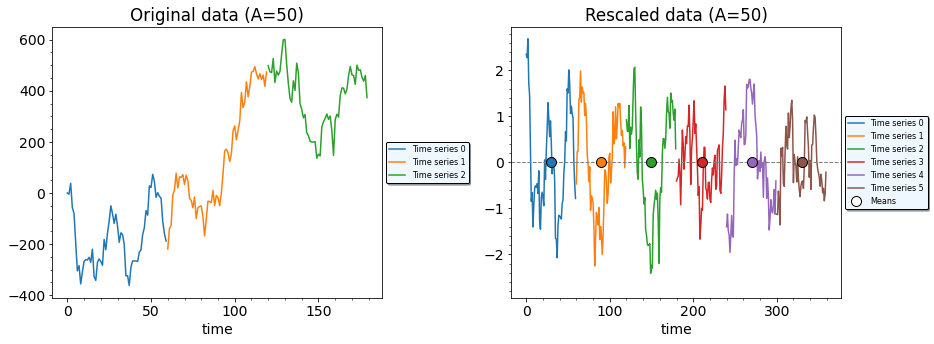

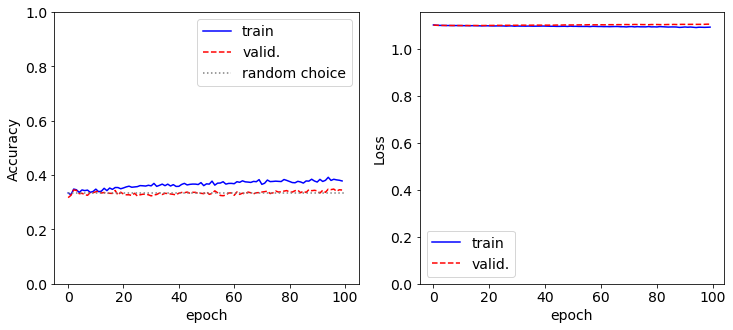

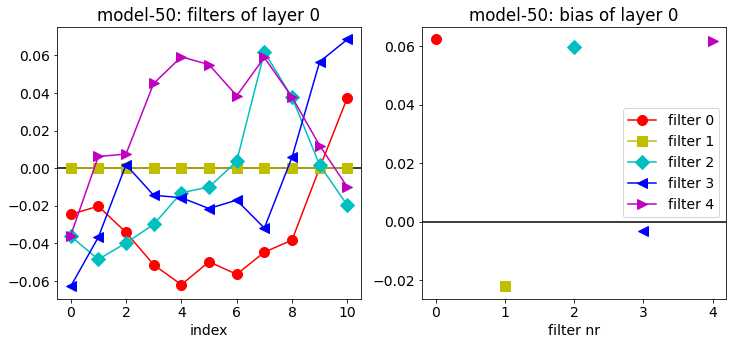

N =  10000 	L =  60 	A =  100


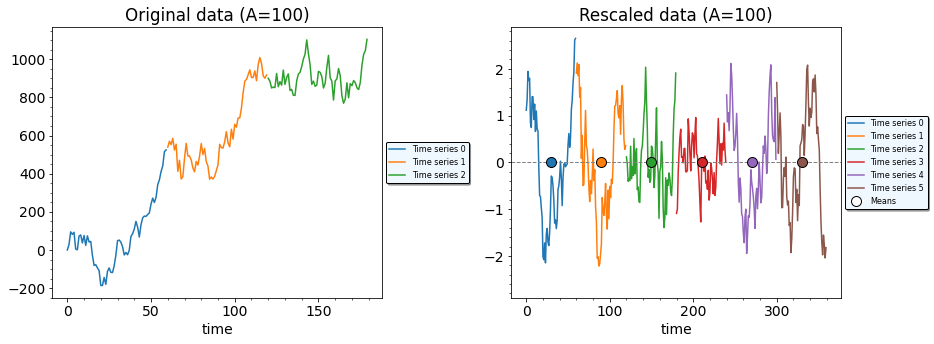

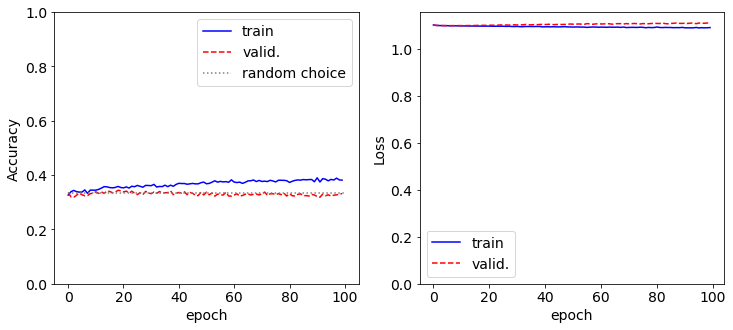

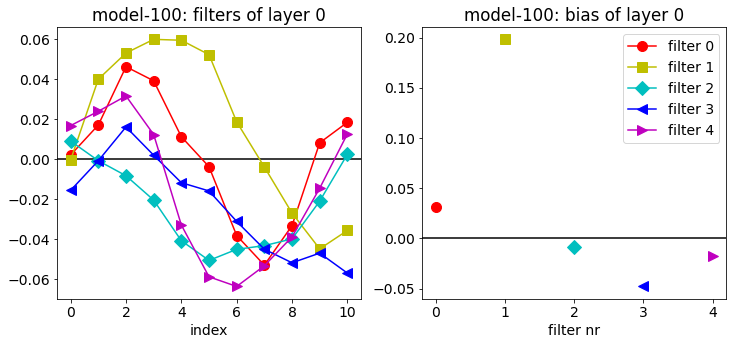

N =  10000 	L =  60 	A =  150


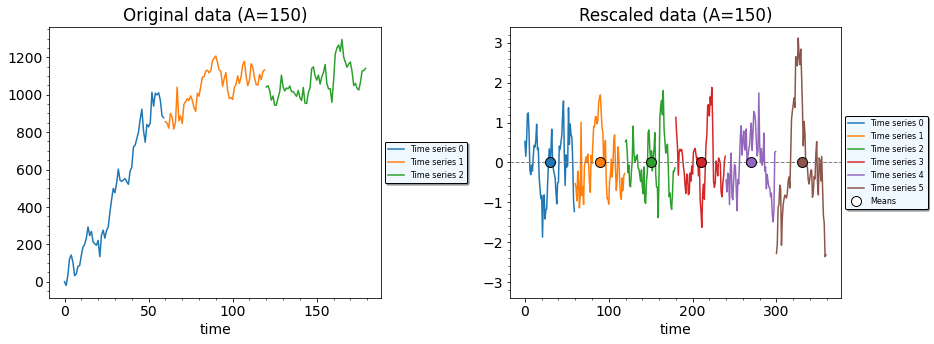

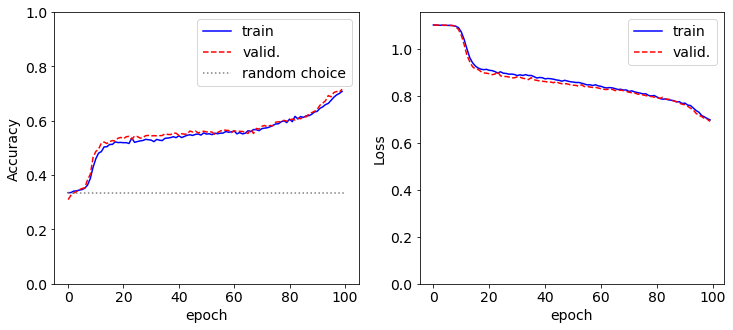

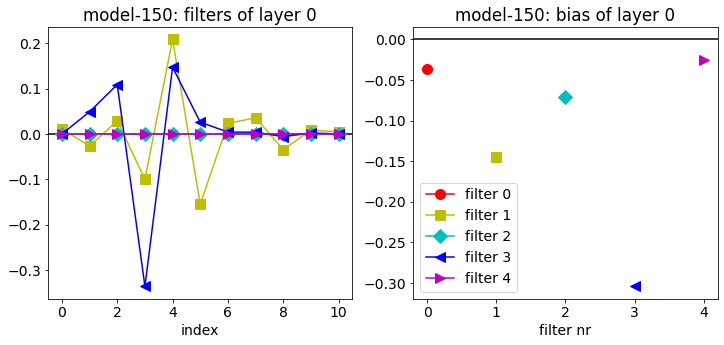

N =  10000 	L =  60 	A =  200


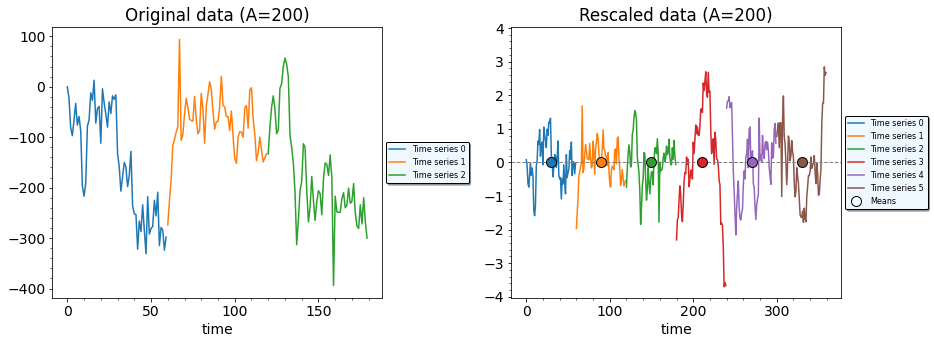

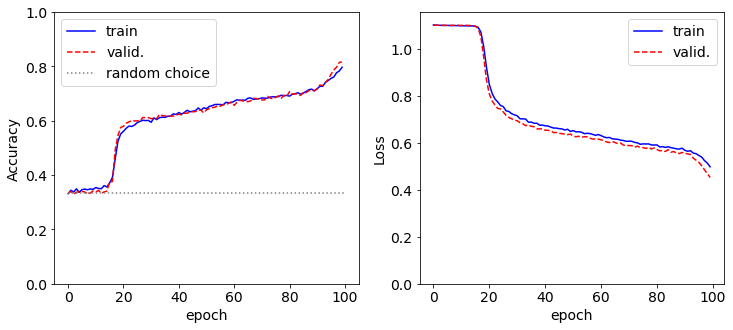

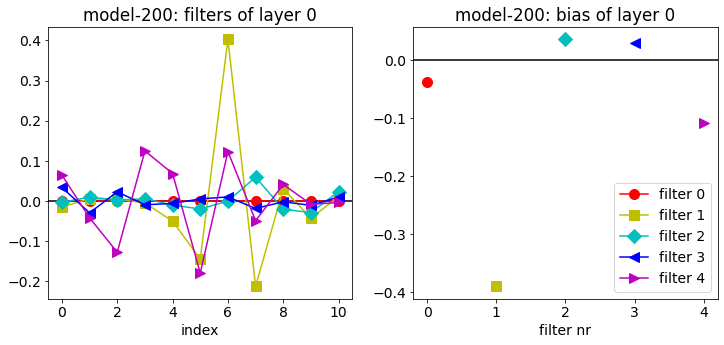

N =  10000 	L =  60 	A =  400


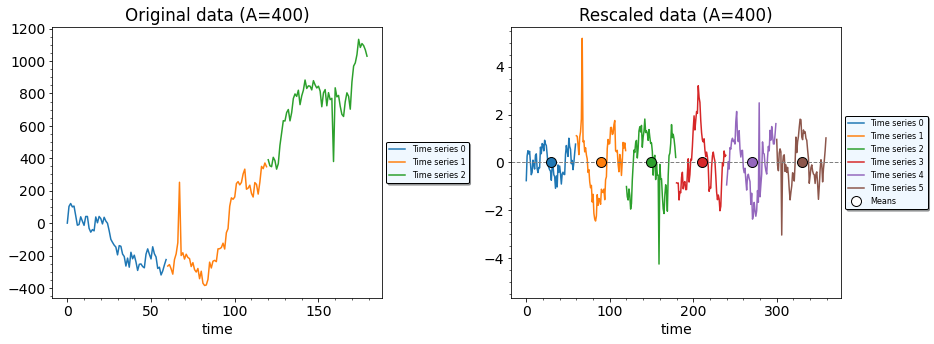

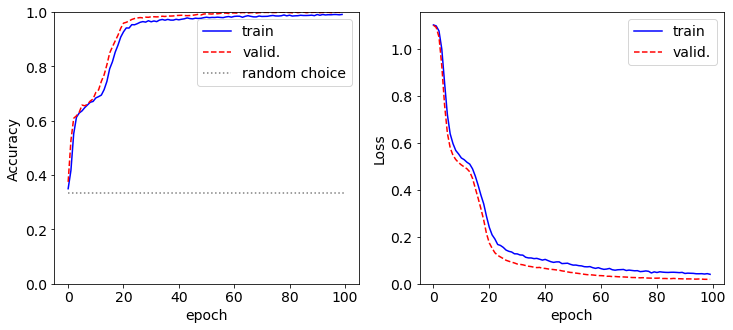

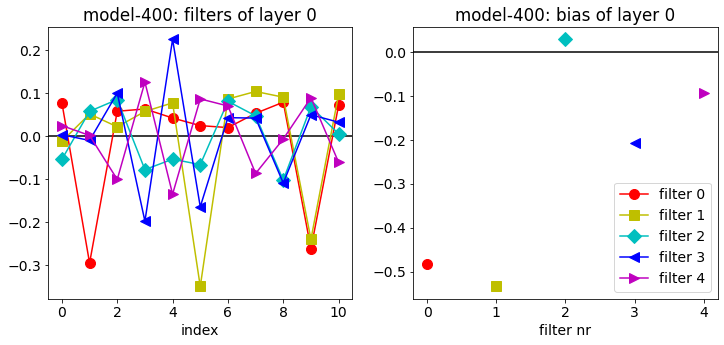

N =  10000 	L =  60 	A =  500


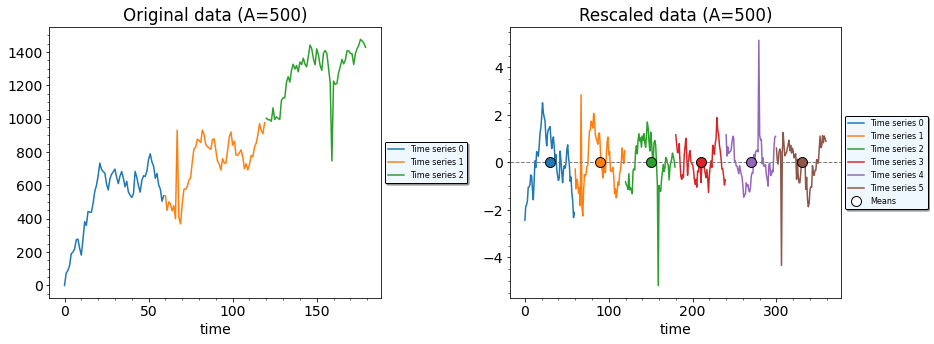

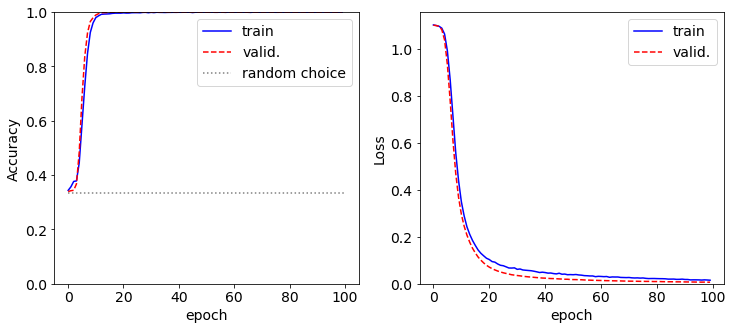

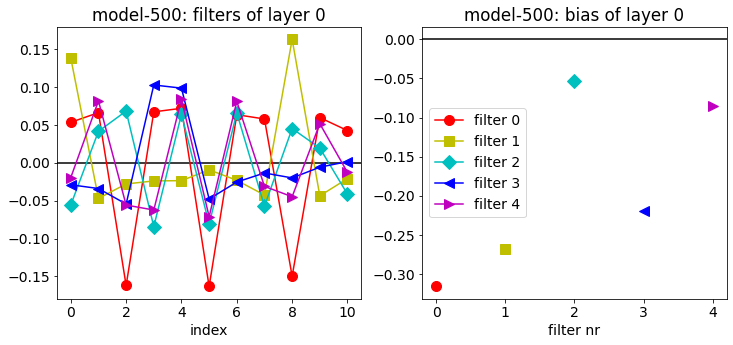

N =  10000 	L =  60 	A =  600


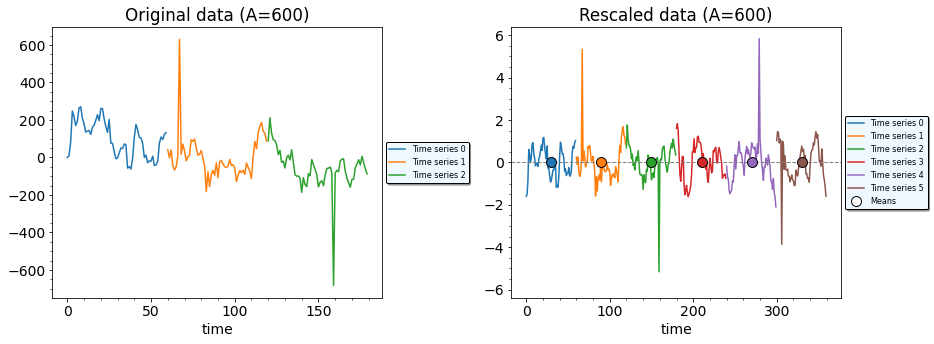

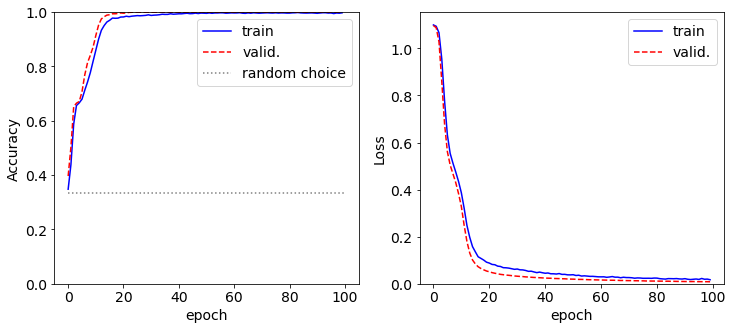

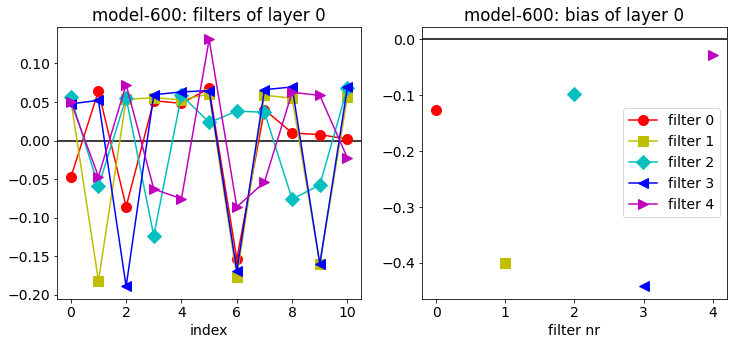

N =  10000 	L =  60 	A =  700


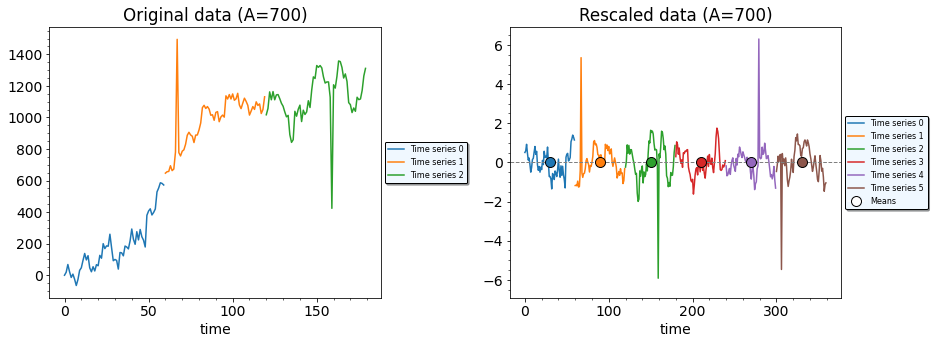

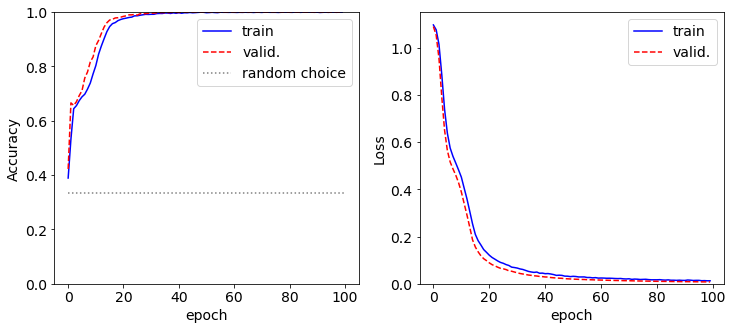

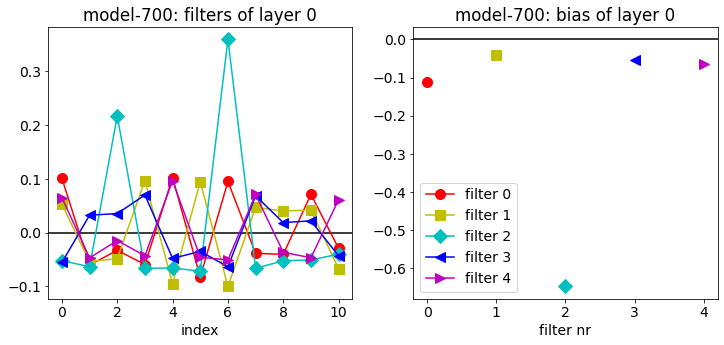

,Amplitude,Training loss,Test loss,Training Accuracy,Test Accuracy
0,50,1.08892584,1.10441744,0.39399999,0.34500000
1,100,1.08725011,1.11000741,0.38912499,0.33149999
2,150,0.66992128,0.69004935,0.72375000,0.71600002
3,200,0.46742836,0.45207295,0.80750000,0.81650001
4,400,0.01810983,0.01928434,0.99900001,0.99750000
5,500,0.00676857,0.00688428,1.00000000,1.00000000
6,600,0.00830029,0.00862703,1.00000000,1.00000000
7,700,0.00797399,0.00795142,1.00000000,1.00000000


In [ ]:
amp_vals = np.array([50, 100, 150, 200, 400, 500, 600, 700])
df= pd.DataFrame(columns=['Amplitude', 'Training loss', 'Test loss', 'Training Accuracy', 'Test Accuracy'])

for amplitude in amp_vals:
    # Read the corresponding data
    fnamex = f'DATA/x_ts_L60_Z12_A{int(amplitude)}_DX50_bias5_N10000.dat'
    fnamey = f'DATA/y_ts_L60_Z12_A{int(amplitude)}_DX50_bias5_N10000.dat'

    x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
    N,L = len(x), len(x[0])
    print('N = ', N, '\tL = ', L , '\tA = ', amplitude)

    # Plot the first 3 samples
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    Show_data(x,L, f"Original data (A={amplitude})", nseries=3, A=None, axis=ax0, show=False)

    # Categories
    categ = np.loadtxt(fnamey, dtype=int)
    n_class = 3    # y.argmax() - y.argmin() +1

    # Convert y to an (N x n_class) matrix
    # --> Directly pass to one hot encoding avoiding the for cycle
    y =tf.keras.utils.to_categorical(categ, n_class)
    
    # remove average value of each sample from its values (NON NECESSARY)
    # xm = x.mean(axis=1)

    # Preprocessing
    x_det = signal.detrend(x) # removes the tilt and centers the data
    x_det = x_det / np.std(x_det)
    
    # Plot the first 6 samples
    Show_data(x_det,L,f"Rescaled data (A={amplitude})", nseries=6, A=None, axis=ax1, show=False, dolegend=False)
    ax1.axhline(0, c="gray", linestyle='--', linewidth=1)
    low, high = plt.ylim()
    bound = bound = max(abs(low), abs(high))
    ax1.set_ylim(-bound, bound)
    # with their mean 
    for i in range(6):
        ax1.plot(L/2*(2*i+1), x_det[i].mean(), marker='o', markersize=10, 
                 markerfacecolor='C'+str(i), markeredgecolor='black')
    ax1.plot([],[], marker='o', markersize=10, markerfacecolor='white', markeredgecolor='black',
             label='Means', c='white')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), 
        shadow=True, framealpha=1, facecolor='aliceblue', edgecolor='black', prop={'size':8})
    plt.show()

    # Splitting into training and validation
    perc_train=0.8
    N_train = int(perc_train*N)
    x_train = x_det[:N_train]
    y_train = y[:N_train]
    x_val = x_det[N_train:]
    y_val = y[N_train:]
    N_val = len(x_val)

    #print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

    #x_train=x_train.astype("float32")
    #y_train=y_train.astype("float32")
    #x_val=x_val.astype("float32")
    #y_val=y_val.astype("float32")

    # Keras wants an additional dimension with a 1 at the end
    x_train = x_train.reshape(x_train.shape[0], L, 1)
    x_val =  x_val.reshape(x_val.shape[0], L, 1)
    input_shape = (L, 1)

    
    # Regularizer and initializer    
    reg = regularizers.l2(0.02)# ridge with lambda
    #reg regularizerts.l1(0.1)
    ini = keras.initializers.RandomNormal(mean=0., stddev=.05, seed=None)


    # Model
    NCONV = 1
    NF = 5 # number of filters

    model = Sequential()
    if NCONV == 1:
        model.add(Conv1D(filters=NF, kernel_size=11, kernel_initializer=ini,
                        kernel_regularizer=reg, activation = 'relu', 
                        input_shape=input_shape))
        
        #model.add(MaxPooling1D(3))
        model.add(AveragePooling1D(5))
        model.add(Conv1D(filters=NF, kernel_size=7,
                        activation='relu'))
        model.add(Flatten())# To be sent to a normal neural network layer
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))
        
    model.add(Dense(n_class, activation='softmax'))

    # Compile the model
    opt= tf.keras.optimizers.Adam()
    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=opt, metrics=['accuracy'])    
    BATCH_SIZE = 250
    EPOCHS = 100


    # Fit the model
    fit = model.fit(x_train, y_train, batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    verbose=0, shuffle=True)
            
    eval_train = model.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
    eval_test = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=0)

    # Plot history, weights
    Show_history(fit)
    Show_weights(model,0,label="model"+str( - amplitude))

    
    # Save metrics in pd Dataframe
    df = pd.concat([df, pd.DataFrame(data=[[amplitude, eval_train[0], eval_test[0], eval_train[1], eval_test[1]]],
                                     columns=df.columns)
                    ], ignore_index=True)

display(df.round(8))

With $A=50$ the resulting test accuracy is very close to a random guess. Indeed, in this case $A$ is equal to $DX$, the standard deviation of the jump applied to each sample, so the neural network is not able to understand the pattern. A similar behaviour occurs with $A=100$, which is still too small for the network to learn. Starting from $A=150$ the network starts to recognize the imposed pattern and the performances continuously increase with $A$.   Indeed, increasing the value of the amplitude the resulting trajectory is more recognizable and the network learns it with more accuracy. It is interesting to notice that for $A=150$ and $A=200$ some filters are probably useless and unnecessary, since their respective weights are zero. 

In all cases, except perhaps the first two, it is very difficult to understand what happens in the layer zero by analyzing the weights of the filters. In fact, the figures show numerous peaks, while the sinusoidal pattern we expected is not present, which would be justified by the fact that the size of the window is the same as the generated pattern. Perhaps, this behavior can be explained by the fact that the peaks are very large with respect to the noisy pattern and therefore it is sufficient to recognize them in a smaller region than in the whole range. More complex processes that take place in subsequent layers would then allow to exclude that the peak is due to some very noisy points rather than to the sinusoidal pattern. But this is only an hypothesis. 


## 3. Grid Search for Regularization
Check if regularization may improve the performances by varying the parameter lambda (as usual in magnitude: $0$, $10^{-5}$, $10^{-4}$, $10^{-3}$, etc.) of the L1 (LASSO) or of the L2 (Ridge) regularization; see lambda in eqs.(43) and (52) in the review. There is also a mixed version (l1_l2) that can be tried.

We decided to use the mixed version (l1_l2).

### Load the data
Here we use $A=400$.

In [ ]:
# Load the data
A_selected = 400
fnamex = f'DATA/x_ts_L60_Z12_A{A_selected}_DX50_bias5_N10000.dat'
fnamey = f'DATA/y_ts_L60_Z12_A{A_selected}_DX50_bias5_N10000.dat'

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N, L = len(x), len(x[0])
print('N = ', N, '\nL = ', L , '\nA = ', A_selected)

# Categories
categ = np.loadtxt(fnamey, dtype=int)

n_class = 3

# Convert y to an (N x n_class) matrix
# --> Directly pass to one hot encoding avoiding the for cycle
y = tf.keras.utils.to_categorical(categ, n_class)

# Preprocessing
x_det = signal.detrend(x) # removes the tilt and centers the data
x_det = x_det / np.std(x_det)


N =  10000 
L =  60 
A =  400


### Training and validation sets

In [ ]:
# Splitting into training and validation
perc_train=0.8

N_train = int(perc_train*N)
x_train = x_det[:N_train]
y_train = y[:N_train]
x_val = x_det[N_train:]
y_val = y[N_train:]
N_val = len(x_val)

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

### Grid search

In [ ]:
def compile_reg(l1=0.0, l2=0.0):

    reg = regularizers.l1_l2(l1=l1, l2=l2)
    
    # initialization
    ini = keras.initializers.RandomNormal(mean=0., stddev=.05, seed=None)


    # Model definition
    NCONV = 1
    NF = 5 # number of filters
    input_shape = (L, 1)

    model = Sequential()
    model.add(Conv1D(filters=NF, kernel_size=11, kernel_initializer=ini,
                        kernel_regularizer=reg, activation='relu', 
                        input_shape=input_shape))   
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=NF, kernel_size=7,
                     kernel_regularizer=reg, activation='relu'))

    model.add(Flatten())# To be sent to a normal neural network layer
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(n_class, activation='softmax'))

    # Compile the model
    opt= tf.keras.optimizers.Adam()
    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=opt, metrics=['accuracy'])    
    
    
    return model

In [ ]:
# Hyper-parameters
lambdas = [0, 1e-05, 1e-03, 0.01, 0.1, 1.0, 10.0]      
param_grid = {'l1':lambdas, 'l2':lambdas}


# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_reg, epochs=1, batch_size=BATCH_SIZE, verbose=0)

<ipython-input-7-05158614bf2b>:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_gridsearch = KerasClassifier(build_fn=compile_reg, epochs=1, batch_size=BATCH_SIZE, verbose=0)


In [ ]:
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

### Grid search results

In [ ]:
# summarize results
results_df = pd.DataFrame(grid.cv_results_).sort_values(by=["rank_test_score"], ascending=True, ignore_index=True)
display(results_df.loc[:,["param_"+k for k in param_grid.keys()]+["mean_test_score","rank_test_score"]])

print("\n\nBest parameters set found:")
display(pd.DataFrame(grid_result.best_params_, index=[0]))
print("\nScore with best parameters:")
print(grid_result.best_score_.round(8))

,param_l1,param_l2,mean_test_score,rank_test_score
0,0.00001,0.001,0.99912500,1
1,0.00001,0,0.99887501,2
2,0,0,0.99850000,3
3,0,0.001,0.99812502,4
4,0.001,0,0.99800000,5
5,0,0.00001,0.99725001,6
6,0.001,0.00001,0.99712500,7
7,0.00001,0.00001,0.99637501,8
8,0.00001,0.01,0.99474999,9
9,0,0.01,0.99462500,10




Best parameters set found:


,l1,l2
0,0.00001,0.001



Score with best parameters:
0.999125


### Base model performance

In [ ]:
# base model
base_model = compile_reg(l1 = 0.0, l2 = 0.0)
fit_base = base_model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                          validation_data=(x_val,y_val), verbose=0, shuffle=True)
base_model.summary()

# compute errors
eval_train = base_model.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
eval_test = base_model.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=0)

print('\n--- Base model performances ---')
print('Training loss: %.4f' % eval_train[0])
print('Test loss: %.4f' % eval_test[0])
print('Training accuracy: %.4f' % eval_train[1])
print('Test accuracy: %.4f' % eval_test[1])

Model: "sequential_205"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_410 (Conv1D)         (None, 50, 5)             60        
                                                                 
 average_pooling1d_205 (Aver  (None, 10, 5)            0         
 agePooling1D)                                                   
                                                                 
 conv1d_411 (Conv1D)         (None, 4, 5)              180       
                                                                 
 flatten_205 (Flatten)       (None, 20)                0         
                                                                 
 dense_410 (Dense)           (None, 12)                252       
                                                                 
 dropout_205 (Dropout)       (None, 12)                0         
                                                    

### Best model performance

In [ ]:
# best model from CV
best_params = grid_result.best_params_
best_model = compile_reg(l1 = best_params['l1'], l2 = best_params['l2'])
fit_best = best_model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                          validation_data=(x_val,y_val), verbose=0, shuffle=True)
best_model.summary()

# compute errors
eval_train = best_model.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
eval_test = best_model.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=0)

print('\n--- Best model performances ---')
print('Training loss: %.4f' % eval_train[0])
print('Test loss: %.4f' % eval_test[0])
print('Training accuracy: %.4f' % eval_train[1])
print('Test accuracy: %.4f' % eval_test[1])

Model: "sequential_206"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_412 (Conv1D)         (None, 50, 5)             60        
                                                                 
 average_pooling1d_206 (Aver  (None, 10, 5)            0         
 agePooling1D)                                                   
                                                                 
 conv1d_413 (Conv1D)         (None, 4, 5)              180       
                                                                 
 flatten_206 (Flatten)       (None, 20)                0         
                                                                 
 dense_412 (Dense)           (None, 12)                252       
                                                                 
 dropout_206 (Dropout)       (None, 12)                0         
                                                    

### History and weights of the base and best models

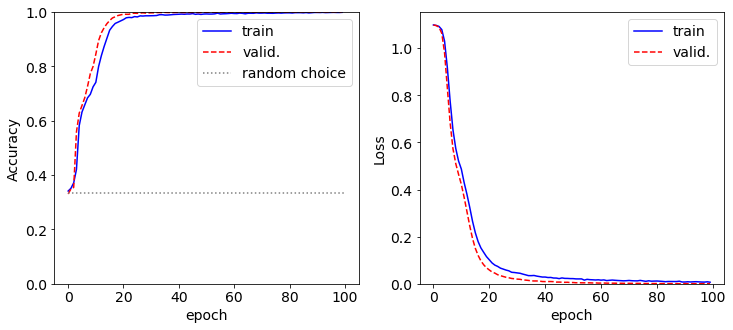

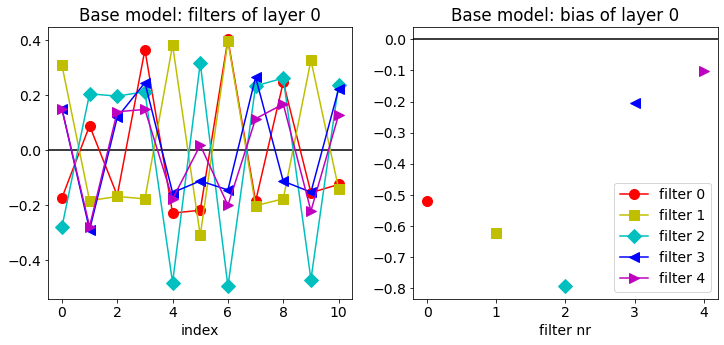

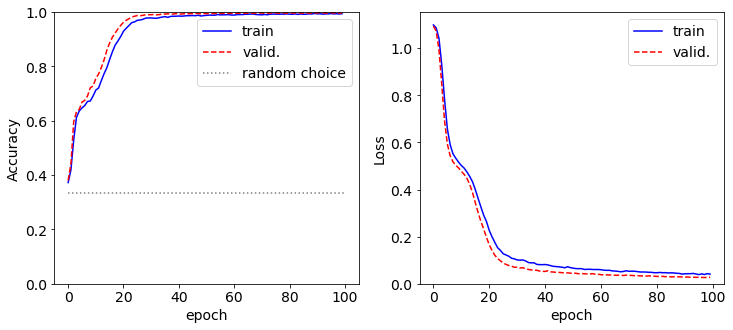

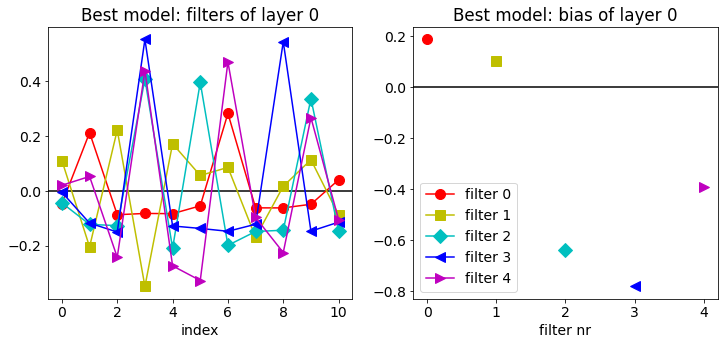

In [ ]:
# show plots
Show_history(fit_base)
Show_weights(base_model, 0, label="Base model")
Show_history(fit_best)
Show_weights(best_model, 0, label="Best model")

- **Are performances of the CNN optimized at some intermediate value of lambda?**
Although the grid search finds a best value of lambdas for both the training and test losses and accuracies, the extremely small values of the optimal lambdas make us suspicious about the real effectiveness of that combination of lambda parameters. In fact, the best combination of parameters is $\lambda_1=10^{-5}$, $\lambda_2 = 10^{-3}$, the second best combination is $\lambda_1=10^{-5}$, $\lambda_2 = 0.0$ and the third one is $\lambda_1=\lambda_2=0$. The regularization has thus a very small impact on the algorithm performances. Moreover, by inspecting even smaller values of $\lambda$ we notice that the preference is to minimize as much as possible $\lambda_2$, compatibly with the grid of parameters. So, the grid search finds an optimal non-zero value of lambdas, but further studies are necessary to decide whether this improvement is real or caused by the randomness of the fit. Moreover, this result is certainly influenced by the fact that the basic model already has excellent performance.

- **Is there any improvement in the visualization and understanding of the weights in the filters?**
From the weights plotted above of the two different models, it is not possible to notice meaningful differences before and after applying the regularization. Both models present many peaks and the weights are always smaller than 0.6 in absolute value. The weights are also well balanced and distributed along all the filter, again without any significant differences between the models. In general a regularized model performs better than a non-regularized one, but in this study the improvement is difficult to appreciate.

## 4. (Optional) Best CNN modeled of 2020-2021 year
Try a CNN modeled around the best one of 2020-2021 year: three convolutional layers, no pooling, and the dense layer of the lesson replaced by a global max pooling. 


### Model

In [ ]:
# Regularizer and initializer    
reg_2021 = regularizers.l2(0.02)
#reg regularizerts.l1(0.1)
ini_2021 = keras.initializers.RandomNormal(mean=0., stddev=.05, seed=None)

NF = 6 # number of filters
model_2021 = Sequential()
model_2021.add(Conv1D(filters=NF, kernel_size=3, kernel_initializer=ini_2021,
                    kernel_regularizer=reg_2021, activation = 'relu', 
                    input_shape=input_shape))
    
model_2021.add(Conv1D(filters=8, kernel_size=9,
                activation='relu'))
model_2021.add(Conv1D(filters=4, kernel_size=3,
                activation='relu'))
model_2021.add(GlobalMaxPooling1D())
model_2021.add(Flatten())# To be sent to a normal neural network layer    
model_2021.add(Dense(n_class, activation='softmax'))
 
model_2021.summary() 


Model: "sequential_207"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_414 (Conv1D)         (None, 58, 6)             24        
                                                                 
 conv1d_415 (Conv1D)         (None, 50, 8)             440       
                                                                 
 conv1d_416 (Conv1D)         (None, 48, 4)             100       
                                                                 
 global_max_pooling1d (Globa  (None, 4)                0         
 lMaxPooling1D)                                                  
                                                                 
 flatten_207 (Flatten)       (None, 4)                 0         
                                                                 
 dense_414 (Dense)           (None, 3)                 15        
                                                    

### Compile and fit the model

In [ ]:
# Compile the model
opt= tf.keras.optimizers.Adam()
model_2021.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=opt, metrics=['accuracy'])    
BATCH_SIZE = 250
EPOCHS = 100

# Fit the model
fit = model_2021.fit(x_train, y_train, batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)
        
eval_train = model_2021.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
eval_test = model_2021.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=0)

### Results

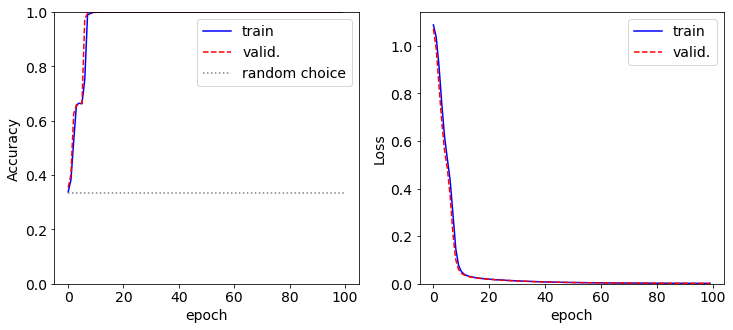

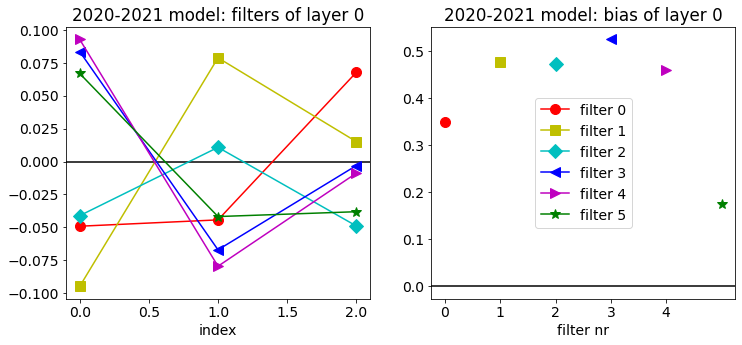

,Amplitude,Training loss,Test loss,Training Accuracy,Test Accuracy
0,400,0.00163102,0.00170139,1.0,1.0


In [ ]:
# Plot history, weights
Show_history(fit)
Show_weights(model_2021,0,label="2020-2021 model")

df_2021=pd.DataFrame(columns=['Amplitude','Training loss', 'Test loss', 'Training Accuracy', 'Test Accuracy'])


# Save metrics in pd Dataframe
df_2021 = pd.concat([df_2021, pd.DataFrame(data=[[A_selected, eval_train[0], eval_test[0], eval_train[1], eval_test[1]]],
                                     columns=df_2021.columns)], ignore_index=True)
display(df_2021.round(8))

**Is it working better? If yes, which could be the reason?** 

As our our best model already had 100% test accuracy with a similar number of parameters, we certainly can't say whether this model works better or not. The only thing we can say is that even this model turns out to have excellent results as regards the training and test losses and accuracies.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c8e8699-579b-4f24-9413-a98afebf04a2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>